Business Insights Summary

This exploratory data analysis evaluates customer behavior across social media campaigns, ad performance by format and platform, and cost efficiency.
Key findings show that purchases cluster later in the funnel (median ~29 days), Stories ads outperform other formats, and campaign ROI varies significantly, which highlights opportunities for budget reallocation.

Success Metrics / KPIs
Conversion Rate
Cost per Conversion (CPA)
Click-Through Rate (CTR) by ad
Purchase Frequency

In [55]:
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
conn = snowflake.connector.connect(
    user='',
    password='',
    account='',
    warehouse='COMPUTE_WH',
    database='Social_Media_Ad',
    schema='Transformed_Data'
)

In [57]:
sns.set_style("whitegrid")
sns.set_palette("pastel")

I. Customer Behavior

1. Identify purchase distribution by day of week and time of day

In [58]:
event_details = pd.read_sql("Select * From event_details",conn)
event_details.head()

/var/folders/_8/896nn9y51zd85v272qswgw840000gn/T/ipykernel_42169/4259693823.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  event_details = pd.read_sql("Select * From event_details",conn)


,EVENT_ID,AD_ID,USER_ID,TIMESTAMP,DAY_OF_WEEK,TIME_OF_DAY,EVENT_TYPE,USER_GENDER,USER_AGE,AGE_GROUP,COUNTRY,LOCATION,INTERESTS,AD_PLATFORM,AD_TYPE,TARGET_GENDER,TARGET_AGE_GROUP,TARGET_INTERESTS
0,1,197,2359b,2025-07-26 00:19:56,Saturday,Night,Like,Female,24,18-24,United States,West Shawna,"gaming, food",Facebook,Stories,All,All,"lifestyle, gaming"
1,2,51,f9c67,2025-06-15 08:28:07,Sunday,Morning,Share,Female,30,25-34,United States,Meyersland,"photography, finance",Instagram,Carousel,All,18-24,photography
2,3,46,5b868,2025-06-27 00:40:02,Friday,Night,Impression,Male,20,18-24,United States,Barrerahaven,"fashion, sports, travel",Instagram,Carousel,All,35-44,"technology, travel"
3,4,166,3d440,2025-06-05 19:20:45,Thursday,Evening,Impression,Female,18,18-24,United States,Lake Angelaland,"food, art",Instagram,Image,All,All,fashion
4,5,52,68f1a,2025-07-22 08:30:29,Tuesday,Morning,Impression,Male,58,55-65,United Kingdom,Robinsonberg,"finance, lifestyle",Instagram,Stories,Female,35-44,"health, lifestyle"


In [59]:
impressions = event_details[event_details['EVENT_TYPE'] == 'Impression']

In [60]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

impression_counts_df = (
    impressions
    .groupby('DAY_OF_WEEK')
    .size()
    .reindex(order, fill_value=0)
    .reset_index(name='count')
)

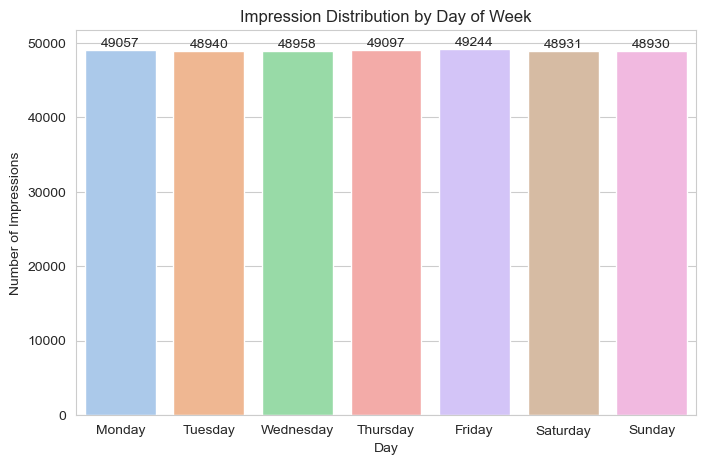

In [61]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=impression_counts_df,
    x='DAY_OF_WEEK',
    y='count',
    order=order
)


plt.title("Impression Distribution by Day of Week")
plt.xlabel("Day")
plt.ylabel("Number of Impressions")

for i, row in impression_counts_df.iterrows():
    plt.text(i, row['count'], int(row['count']),
             ha='center', va='bottom')

plt.show()

In [62]:
user_journey = pd.read_sql("SELECT * FROM user_journey", conn)

/var/folders/_8/896nn9y51zd85v272qswgw840000gn/T/ipykernel_42169/4211969036.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  user_journey = pd.read_sql("SELECT * FROM user_journey", conn)


In [63]:
query = "SELECT * FROM user_journey;" 
df = pd.read_sql(query, conn)
df.head()

/var/folders/_8/896nn9y51zd85v272qswgw840000gn/T/ipykernel_42169/629996373.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,USER_ID,AD_ID,EVENT_TYPE,AD_PLATFORM,TARGET_INTERESTS,AD_TYPE,TIME_OF_DAY,TIMESTAMP,DAY_OF_WEEK
0,00336,190,Purchase,Facebook,"photography, technology",Image,Night,2025-06-20 04:26:46,Fri
1,00545,38,Purchase,Facebook,"finance, technology",Stories,Afternoon,2025-06-03 17:34:35,Tue
2,00545,92,Purchase,Facebook,gaming,Carousel,Morning,2025-06-26 07:18:59,Thu
3,00567,56,Purchase,Instagram,news,Stories,Evening,2025-06-13 22:23:09,Fri
4,006b2,192,Purchase,Facebook,fashion,Carousel,Morning,2025-07-16 07:01:59,Wed


In [64]:
purchase_df = df[df['EVENT_TYPE'] == 'Purchase']

In [65]:
order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

counts_df = (
    purchase_df
    .groupby('DAY_OF_WEEK')
    .size()
    .reset_index(name='count')
)


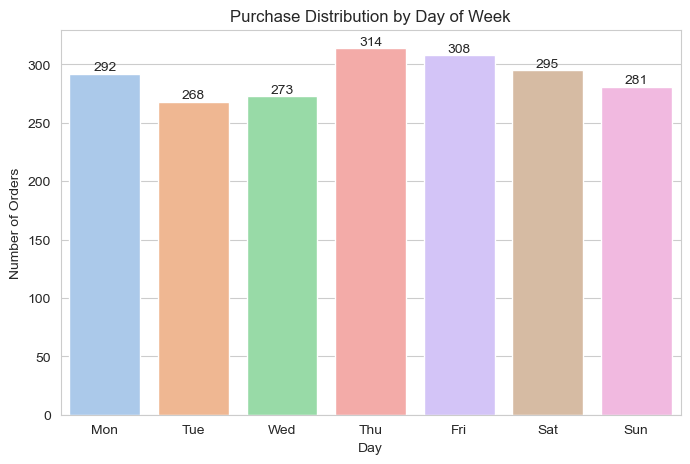

In [66]:
plt.figure(figsize=(8,5))
sns.barplot(data=counts_df, x='DAY_OF_WEEK', y='count',order=order)

plt.title("Purchase Distribution by Day of Week")
plt.xlabel("Day")
plt.ylabel("Number of Orders")

for i, day in enumerate(order):
    value = counts_df.loc[counts_df['DAY_OF_WEEK'] == day, 'count'].values
    if len(value) > 0:
        plt.text(i, value[0], int(value[0]), ha='center', va='bottom')


plt.show()

In [67]:
purchase_count = purchase_df.groupby('TIME_OF_DAY').size()

In [68]:
order = ['Morning', 'Afternoon', 'Evening', 'Night']

counts_df = (
    purchase_count
    .reindex(order)
    .reset_index(name='count')
)

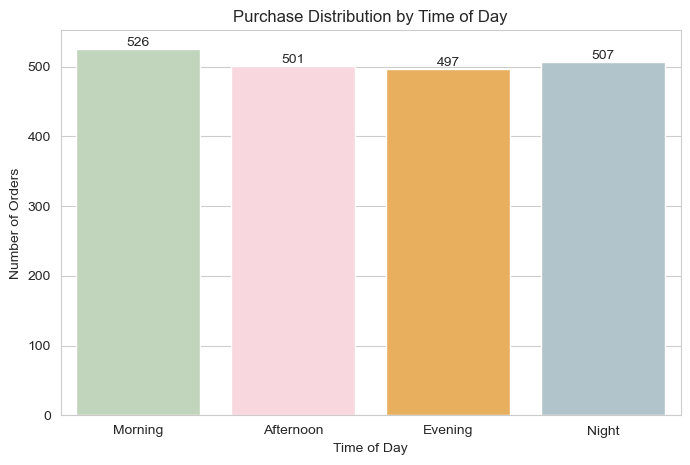

In [69]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=counts_df,
    x='TIME_OF_DAY',
    y='count',
    palette=['#BFD8B8', '#FFD1DC', '#FFB347', '#AEC6CF']
)

plt.title("Purchase Distribution by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Orders")

for i, v in enumerate(counts_df['count']):
    plt.text(i, v, int(v), ha='center', va='bottom')

plt.show()

Although the impression distribution is even throughout the week, the purchase distribution peaks on Thursdays and Fridays and purchase behavior is the weakest on Tuesdays and Wednesdays. The purchase behaviors are the strongest in the morning and second at night.

2. Analyze the user journey to identify how many touchpoints occur before purchase

On average, users experience 0.08 recorded touchpoints prior to purchase, indicating that most conversions occur without multiple tracked interactions. The maximum observed was 2 touchpoints, suggesting a relatively short or under-tracked decision journey.

In [70]:
touchpoints = user_journey[user_journey['EVENT_TYPE'].isin(['Impression', 'Click', 'Purchase'])]

touchpoint_summary = (
    touchpoints
    .groupby(['USER_ID', 'AD_ID'])
    .agg(
        impressions=('EVENT_TYPE', lambda x: (x == 'Impression').sum()),
        clicks=('EVENT_TYPE', lambda x: (x == 'Click').sum()),
        likes=('EVENT_TYPE', lambda x: (x == 'Like').sum()),
        shares=('EVENT_TYPE', lambda x: (x == 'Share').sum())
    )
    .reset_index()
)

touchpoint_summary['total_touchpoints'] = (
    touchpoint_summary['impressions'] + touchpoint_summary['clicks']+touchpoint_summary['likes']+touchpoint_summary['shares']
)

touchpoint_summary.head(20)

,USER_ID,AD_ID,impressions,clicks,likes,shares,total_touchpoints
0,00336,190,0,0,0,0,0
1,00545,38,0,0,0,0,0
2,00545,92,0,0,0,0,0
3,00567,56,0,0,0,0,0
4,006b2,192,0,0,0,0,0
5,0073a,165,0,0,0,0,0
6,007fb,39,0,0,0,0,0
7,00d31,192,2,0,0,0,2
8,00e8d,157,0,0,0,0,0
9,00f82,64,0,0,0,0,0


In [71]:
touchpoint_summary.describe().round(2)

,AD_ID,impressions,clicks,likes,shares,total_touchpoints
count,2031.00,2031.00,2031.00,2031.0,2031.0,2031.00
mean,99.24,0.08,0.01,0.0,0.0,0.08
std,58.09,0.28,0.08,0.0,0.0,0.29
min,1.00,0.00,0.00,0.0,0.0,0.00
25%,49.00,0.00,0.00,0.0,0.0,0.00
50%,97.00,0.00,0.00,0.0,0.0,0.00
75%,150.00,0.00,0.00,0.0,0.0,0.00
max,200.00,2.00,1.00,0.0,0.0,2.00


In [72]:
touchpoint_summary.groupby('AD_ID')['total_touchpoints'].mean().round(2)

AD_ID
1      0.00
2      0.23
3      0.15
4      0.08
5      0.09
       ... 
196    0.00
197    0.00
198    0.00
199    0.00
200    0.00
Name: total_touchpoints, Length: 200, dtype: float64

3. Measure time from impression to purchase

In [73]:
query='SELECT * from user_time_to_purchase where days_to_purchase is not null;'
user_time_to_purchase = pd.read_sql(query, conn)
user_time_to_purchase.head()

/var/folders/_8/896nn9y51zd85v272qswgw840000gn/T/ipykernel_42169/1981208588.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  user_time_to_purchase = pd.read_sql(query, conn)


,USER_ID,AD_ID,FIRST_TOUCH_TIME,PURCHASE_TIME,HOURS_TO_PURCHASE,DAYS_TO_PURCHASE
0,19cc6,69,2025-05-17 22:37:10,2025-08-03 23:03:38,1873,78
1,af91d,78,2025-05-22 04:30:08,2025-08-06 08:18:10,1828,76
2,ea0ab,186,2025-05-19 01:51:48,2025-07-30 21:27:47,1748,72
3,61c2e,4,2025-05-28 08:51:50,2025-08-04 08:24:56,1632,68
4,bd013,44,2025-05-15 10:06:43,2025-07-20 13:57:27,1587,66


In [74]:
user_time_to_purchase.describe().round(2)

,AD_ID,FIRST_TOUCH_TIME,PURCHASE_TIME,HOURS_TO_PURCHASE,DAYS_TO_PURCHASE
count,157.00,157,157,157.00,157.00
mean,95.98,2025-06-07 20:51:12.031847424,2025-07-06 10:40:00.694267392,685.79,28.59
min,2.00,2025-05-08 16:14:11,2025-05-15 00:59:02,6.00,0.00
25%,49.00,2025-05-22 01:56:32,2025-06-21 18:54:44,264.00,11.00
50%,94.00,2025-06-04 22:18:19,2025-07-06 22:31:35,695.00,29.00
75%,143.00,2025-06-19 17:08:19,2025-07-25 02:31:17,1017.00,43.00
max,194.00,2025-08-02 18:53:31,2025-08-06 08:18:10,1873.00,78.00
std,56.29,NaN,NaN,460.14,19.18


In [75]:
user_time_to_purchase.columns = user_time_to_purchase.columns.str.upper()

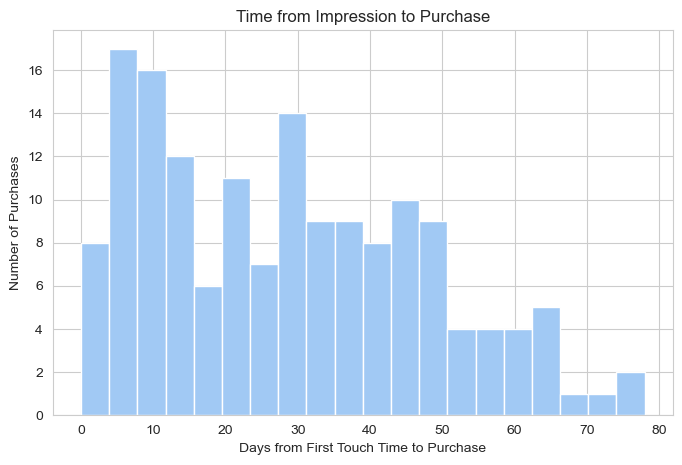

In [76]:
plt.figure(figsize=(8,5))
plt.hist(user_time_to_purchase['DAYS_TO_PURCHASE'], bins=20)
plt.xlabel('Days from First Touch Time to Purchase')
plt.ylabel('Number of Purchases')
plt.title('Time from Impression to Purchase')
plt.show()

The median time to purchase is 29 days, with most purchases occurring between 11 and 43 days after first impression. This suggests that remarketing and longer attribution windows are critical, as conversions often occur weeks after initial exposure.

II. Campaign Performance

1. Compare performance across platforms

In [77]:
user_time_to_purchase.merge(
    user_journey[['USER_ID','AD_ID','AD_PLATFORM']].drop_duplicates(),
    on=['USER_ID','AD_ID']
).groupby('AD_PLATFORM')['DAYS_TO_PURCHASE'].mean()

AD_PLATFORM
Facebook     29.018018
Instagram    27.565217
Name: DAYS_TO_PURCHASE, dtype: float64

The dataset contains social media campaigns on Facebook and Instagram. On average, customers purchase from ads on Facebook within 29.018018 days after impression, and 27.565217 days on Instagram. Instagram conversions occur around 1.5 days faster on average than Facebook, suggesting a slightly shorter decision cycle on Instagram, though overall behavior is similar across platforms.

2. Calculate purchase event percentage (conversion rate)

The conversion rate is calculated as the number of purchase events divided by the number of impressions, multiplied by 100 to express the result as a percentage:

Conversion Rate = (Purchase Events / Impressions) × 100

To accurately evaluate individual ad performance, conversion rates are grouped by AD_ID, ensuring that each ad’s effectiveness is measured independently rather than aggregated at the campaign or platform level. This approach allows for more precise comparisons across ad creatives and formats and supports data-driven optimization decisions.
Grouping by ad ensures that high-performing creatives are not diluted by lower-performing ads within the same campaign, enabling more targeted budget reallocation and creative optimization.

In [78]:
query="Select * From event_details;"
event_details=pd.read_sql(query, conn)
event_details.head()

/var/folders/_8/896nn9y51zd85v272qswgw840000gn/T/ipykernel_42169/4151614608.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  event_details=pd.read_sql(query, conn)


,EVENT_ID,AD_ID,USER_ID,TIMESTAMP,DAY_OF_WEEK,TIME_OF_DAY,EVENT_TYPE,USER_GENDER,USER_AGE,AGE_GROUP,COUNTRY,LOCATION,INTERESTS,AD_PLATFORM,AD_TYPE,TARGET_GENDER,TARGET_AGE_GROUP,TARGET_INTERESTS
0,1,197,2359b,2025-07-26 00:19:56,Saturday,Night,Like,Female,24,18-24,United States,West Shawna,"gaming, food",Facebook,Stories,All,All,"lifestyle, gaming"
1,2,51,f9c67,2025-06-15 08:28:07,Sunday,Morning,Share,Female,30,25-34,United States,Meyersland,"photography, finance",Instagram,Carousel,All,18-24,photography
2,3,46,5b868,2025-06-27 00:40:02,Friday,Night,Impression,Male,20,18-24,United States,Barrerahaven,"fashion, sports, travel",Instagram,Carousel,All,35-44,"technology, travel"
3,4,166,3d440,2025-06-05 19:20:45,Thursday,Evening,Impression,Female,18,18-24,United States,Lake Angelaland,"food, art",Instagram,Image,All,All,fashion
4,5,52,68f1a,2025-07-22 08:30:29,Tuesday,Morning,Impression,Male,58,55-65,United Kingdom,Robinsonberg,"finance, lifestyle",Instagram,Stories,Female,35-44,"health, lifestyle"


In [79]:
impressions = (
    event_details[event_details['EVENT_TYPE'] == 'Impression']
    .groupby('AD_ID')
    .size()
    .reset_index(name='impressions')
)

conversion_rate_imp = (
    impressions
    .merge(purchase_events, on='AD_ID', how='left')
    .fillna(0)
)

conversion_rate_imp['conversion_rate_pct'] = (
    conversion_rate_imp['purchase_events'] / conversion_rate_imp['impressions'] * 100
).round(2)

conversion_rate_imp


,AD_ID,impressions,purchase_events,conversion_rate_pct
0,1,1755,8,0.46
1,2,1771,13,0.73
2,3,1676,13,0.78
3,4,1763,12,0.68
4,5,1708,11,0.64
...,...,...,...,...
195,196,1707,5,0.29
196,197,1709,13,0.76
197,198,1687,14,0.83
198,199,1716,9,0.52


3. Identify highest-performing ad types

In [80]:
ad_conversion = (
    total_events
    .merge(purchase_events, on='AD_ID', how='left')
    .fillna(0)
)

ad_conversion['conversion_rate_pct'] = (
    ad_conversion['purchase_events'] / ad_conversion['total_events'] * 100
)

In [81]:
ad_conversion = ad_conversion.merge(
    event_details[['AD_ID', 'AD_TYPE']],
    on='AD_ID',
    how='left'
)

In [82]:
ad_type_performance = (
    ad_conversion
    .groupby('AD_TYPE')
    .agg(
        avg_conversion_rate=('conversion_rate_pct', 'mean'),
        total_ads=('AD_ID', 'nunique')
    )
    .reset_index()
    .sort_values('avg_conversion_rate', ascending=False)
).round(2)

ad_type_performance

,AD_TYPE,avg_conversion_rate,total_ads
2,Stories,0.53,64
3,Video,0.52,33
0,Carousel,0.51,51
1,Image,0.47,52


Out of the 200 ads, Stories have the highest conversion rate of 0.53 and image has the lowest conversion rate of 0.47. Stories ads outperform Images by 6%, suggesting short-form, immersive formats drive higher intent.

4. Evaluate effectiveness by user interest segment

In [83]:
interest_perf = (
    event_details
    .groupby('TARGET_INTERESTS')
    .agg(
        total_users=('USER_ID', 'nunique'),
        purchasers=('EVENT_TYPE', lambda x: (x == 'Purchase').sum())
    )
    .reset_index()
)

interest_perf['conversion_rate'] = (
    interest_perf['purchasers'] / interest_perf['total_users']
)

interest_perf.sort_values('conversion_rate', ascending=False)

,TARGET_INTERESTS,total_users,purchasers,conversion_rate
57,news,9069,146,0.016099
7,fashion,9024,123,0.013630
0,art,8607,113,0.013129
63,photography,9042,113,0.012497
43,health,7973,92,0.011539
...,...,...,...,...
35,"gaming, art",1777,6,0.003376
16,"finance, news",1783,6,0.003365
10,"fashion, news",1789,5,0.002795
40,"gaming, sports",1816,5,0.002753


While overall conversion rates are low across interest segments, News, Fashion, and Art outperform others, indicating higher intent audiences despite similar user volumes. These segments are strong candidates for budget prioritization or tailored creative.

III. Cost Efficiency

1. Calculate cost per conversion and identify high-ROI campaigns

In [84]:
query = "SELECT * FROM Cost_Per_Conversion order by Cost_Per_Conversion asc;" 
cpc = pd.read_sql(query, conn)
cpc.head(20)

/var/folders/_8/896nn9y51zd85v272qswgw840000gn/T/ipykernel_42169/4095012468.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cpc = pd.read_sql(query, conn)


,CAMPAIGN_ID,AD_ID,TOTAL_BUDGET,NUMBER_OF_ADS,BUDGET_PER_AD,PURCHASE_COUNT,COST_PER_CONVERSION
0,42,101,7918.04,8,989.76,12,82.48
1,42,70,7918.04,8,989.76,11,89.98
2,42,111,7918.04,8,989.76,9,109.97
3,42,167,7918.04,8,989.76,8,123.72
4,42,48,7918.04,8,989.76,8,123.72
5,42,160,7918.04,8,989.76,7,141.39
6,42,117,7918.04,8,989.76,7,141.39
7,42,26,7918.04,8,989.76,5,197.95
8,29,25,19773.66,7,2824.81,14,201.77
9,13,53,21855.42,6,3642.57,15,242.84


In [85]:
query = "SELECT * FROM Cost_Per_Conversion order by Cost_Per_Conversion desc;" 
cpc = pd.read_sql(query, conn)
cpc.head(20)

/var/folders/_8/896nn9y51zd85v272qswgw840000gn/T/ipykernel_42169/1961927929.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cpc = pd.read_sql(query, conn)


,CAMPAIGN_ID,AD_ID,TOTAL_BUDGET,NUMBER_OF_ADS,BUDGET_PER_AD,PURCHASE_COUNT,COST_PER_CONVERSION
0,46,80,94023.76,5,18804.75,1,18804.75
1,32,72,81744.53,4,20436.13,2,10218.07
2,36,95,58801.99,2,29401.00,3,9800.33
3,35,43,71626.83,1,71626.83,11,6511.53
4,50,100,47274.70,1,47274.70,8,5909.34
5,36,185,58801.99,2,29401.00,7,4200.14
6,6,162,78607.49,3,26202.50,7,3743.21
7,41,128,85220.35,3,28406.78,8,3550.85
8,15,113,85407.23,5,17081.45,5,3416.29
9,2,52,79342.41,3,26447.47,8,3305.93


Campaign 42 demonstrates strong efficiency, with conversion costs as low as USD82.48, while Campaign 46 shows severe inefficiency at USD18,804.75 per conversion. This gap suggests immediate opportunities for budget reallocation, creative refresh, or campaign pausing.

Key Recommendations

* Reallocate budget toward Stories ads and Campaign 42–like structures
* Extend attribution windows and remarketing efforts beyond 30 days
* Reduce spend or re-optimize high-CPA campaigns.
* Focus targeting on News, Fashion, and Art interest segments
